In [49]:
import sys
import os

current_directory = os.getcwd()        
parent_directory = os.path.dirname(current_directory)
sys.path.append(parent_directory)


from spektral.layers import GCNConv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import sqrt
from tensorflow import keras
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *

from postprocess.threshold import flood_threshold, drought_threshold
from preprocess.BaselinePrerocess import baseline_process, baseline_process_for_gate_predictor


import pygad
import time

In [50]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

### Preprocess

In [51]:
# ====== preprocessing parameters ======
n_hours = 72
K = 24 
masked_value = 1e-10
split_1 = 0.8
split_2 = 0.9

In [52]:
train_X_mask, val_X_mask, test_X_mask, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler = baseline_process(n_hours, K, masked_value, split_1, split_2)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')


In [53]:
print(train_X_mask.shape, val_X_mask.shape, test_X_mask.shape, train_ws_y.shape, val_ws_y.shape, test_ws_y.shape)

(77069, 96, 16) (9634, 96, 16) (19268, 96, 16) (77069, 96) (9634, 96) (19268, 96)


### Select event

In [54]:
# start_idx = 8200
# end_idx = 8700

start_idx = 8250
end_idx = 8350
duration = end_idx - start_idx

In [55]:
ws1 = test_ws_y[start_idx:end_idx, :]
ws1 = ws_scaler.inverse_transform(ws1)
ws1.shape

(100, 96)

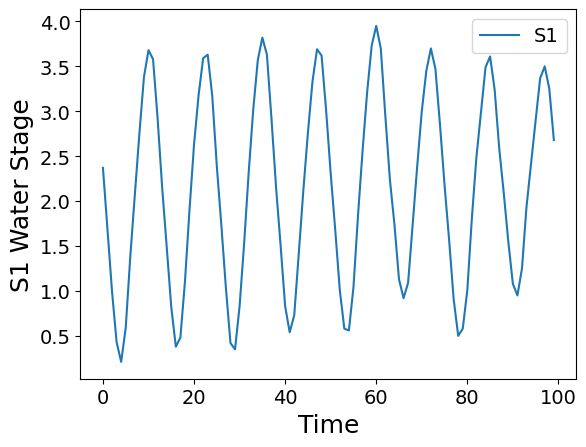

In [56]:
plt.plot(ws1[:, 0], label='S1')
plt.xlabel('Time', fontsize=18)
plt.ylabel('S1 Water Stage', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

### Get optimizable and not optimizable variables

In [57]:
X = test_X_mask[start_idx:end_idx, :, :]
X_1d = np.reshape(X, -1)

print(X.shape)
print(X_1d.shape)

(100, 96, 16)
(153600,)


In [58]:
gate_state = test_X_mask[start_idx:end_idx, :, 2:9]
gate_state_1d = np.reshape(gate_state, -1)

print(gate_state.shape)
print(gate_state_1d.shape)

(100, 96, 7)
(67200,)


In [59]:
not_gate1 = test_X_mask[start_idx:end_idx, :, 0:2]

print(not_gate1.shape)

(100, 96, 2)


In [60]:
not_gate2 = test_X_mask[start_idx:end_idx, :, 9:]

print(not_gate2.shape)

(100, 96, 7)


### GA

In [61]:
saved_model = load_model('../saved_models/cnn.h5', compile=False)

In [62]:
def fitness_func(ga_instance, solution, solution_idx):
    # reshape gate to 3d
    solution = np.reshape(solution, (duration, 96, 7))
    
    # get input numpy
    input_np = np.zeros(((duration, 96, 16)))
    input_np[:, :, 0:2] = not_gate1
    input_np[:, :, 2:9] = solution
    input_np[:, :, 9:] = not_gate2
    
    yhat = saved_model.predict(input_np)
#     yhat = saved_model.predict(input_np, verbose=0)
    
    y_max = 0.62
    y_min = 0.2
    
    penalty_sum = 0
    for i in range (duration):
        for j in range (96):
            if (yhat[i, j] > y_max):
                penalty = np.abs(yhat[i, j] - y_max) + 20*np.abs(yhat[i, j] - y_max)**2
            elif (yhat[i, j] < y_min):
                penalty = np.abs(y_min - yhat[i, j])
                
            else:
                penalty = 0
            
            penalty_sum += penalty
    
    
    if penalty_sum == 0:
        fitness = 9999999999999
    else:
        fitness = 1.0 / penalty_sum
    return fitness

In [63]:
fitness_function = fitness_func

num_generations = 500
num_parents_mating = 8

sol_per_pop = 64
num_genes = len(gate_state_1d)

init_range_low = 0
init_range_high = 1

parent_selection_type = "sss"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 5

In [64]:
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       gene_space = {'low': 0, 'high': 1})

In [ ]:
start_time = time.perf_counter()
ga_instance.run()
cpu_time = time.perf_counter() - start_time
print(f"CPU time: {cpu_time} seconds")

4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 3ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 3ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 3ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 3ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


In [ ]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

### Post-processing

In [ ]:
best_gate = np.reshape(solution, (duration, 96, 7))

best_input = np.zeros(((duration, 96, 16)))
best_input[:, :, 0:2] = not_gate1
best_input[:, :, 2:9] = best_gate
best_input[:, :, 9:] = not_gate2

best_perf = saved_model.predict(best_input)
best_perf = ws_scaler.inverse_transform(best_perf)

In [ ]:
count = 0

for i in range (duration):
    for j in range (96):
        if best_perf[i, j] > 3.5:
            count += 1

print(count)

In [ ]:
plt.plot(best_perf[:, 0], label='S1')
plt.xlabel('Time', fontsize=18)
plt.ylabel('S1 Water Stage', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [ ]:
# Optimal_gate = pd.DataFrame(best_gate.reshape(duration, -1) )
# Optimal_gate.to_csv("GA results/best_gate_event2.csv", index=False)
# Optimal_gate

In [ ]:
# Optimal_case = pd.DataFrame(best_perf)
# Optimal_case.to_csv("GA_results/best_performance_event2.csv", index=False)
# Optimal_case

In [ ]:
# Optimal_case = pd.read_csv("GA_results/best_performance_event2.csv")
# Optimal_case

In [ ]:
upper_threshold = 3.5
lower_threshold = 0

Optimal_case_reshape = best_perf.reshape((-1, 24, 4))

flood_threshold(Optimal_case_reshape, upper_threshold)
drought_threshold(Optimal_case_reshape, lower_threshold)

In [ ]:
true_ws = saved_model.predict([test_X_mask[start_idx:end_idx]])
true_ws = ws_scaler.inverse_transform(true_ws)

true_ws = true_ws.reshape((-1, 24, 4))
flood_threshold(true_ws, upper_threshold)
drought_threshold(true_ws, lower_threshold)